In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Proprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# XGBoost Model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna

# For reproducibility
from teachopencadd.utils import seed_everything
SEED = 42
seed_everything(SEED)

In [2]:
train_file_path_scat = '../Data/Data/train_filter_scat.csv'
train_df_scat = pd.read_csv(train_file_path_scat)

train_file_path_UMAP = '../Data/Data/train_filter_UMAP.csv'
train_df_UMAP = pd.read_csv(train_file_path_UMAP)

train_file_path_hyb = '../Data/Data/train_filter_UMAP.csv'
train_df_hyb = pd.read_csv(train_file_path_hyb)

In [3]:
train_df_scat.dtypes[train_df_scat.dtypes == 'object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
SaleType         object
SaleCondition    object
dtype: object

# Pipelines

In [4]:
ode_cols = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
ohe_cols = ['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']
num_cols = train_df_scat.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop("SalePrice")

In [5]:
# from the sklearn.pipeline module
# assembles several steps that can be cross-validated together while setting different parameters.
# steps parameter is a list of tuples where each tuple represents a step in the pipeline

#impute is the name of the step
### SimpleImputer is a method from sklearn.impute module, fills in missing values in dataset
### strategy='mean' is the parameter, missing value replaceded by the mean value of corresponding feature

### scaler is the name of the next step
### StandardScaler is a method from sklearn.preprocessing module
### It standardizes features by removing the mean and scaling to unit variance
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#impute is the name of the step
### SimpleImputer is a method from sklearn.impute module, fills in missing values in dataset
### strategy='most frequent' is the parameter, missing value replaceded by the most frequent value of corresponding feature

### ohe is the name of the next step
### OneHotEncoder is a method from sklearn.preprocessing module and encodes categorical features as a one-hot numeric array
### handle_unknown='ignore' is the parameter, unknown categories are ignored
### sparse_output=False is a parameter, returns a dense array instead of a sparse matrix
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### ode is the name of the step
### OrdinalEncoder is a method from sklearn.preprocessing module and encodes categorical features as an ordinal numeric array
### handle_unknown='use_encoded_value' is the parameter, unknown categories are encoded with a user-specified value
### where the value is -1, set by unknown_value=-1
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

])

### ColumnTransformer is a method from sklearn.compose module
### Used to apply preprocessing pipelines to subsets of features in a dataset
### 'num_p', 'ode_p', 'ohe_p' are the names of the transformers
### num_pipeline, ode_pipeline, ohe_pipeline are the pipelines
### num_cols, ode_cols, ohe_cols are the columns to apply the pipelines to

### remaining columns should be passed through without any changes
# n_jobs=-1 uses all processors available
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough',
    n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [6]:
X = train_df_scat.drop('SalePrice', axis=1)
Y = train_df_scat['SalePrice']

# Pass the data through the pipeline
X_preprocessed = pipeline.fit_transform(X)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(X_preprocessed, Y, test_size=0.2, random_state=SEED)

# XGBoost

In [7]:
from xgboost import XGBRegressor

In [8]:
XGB = XGBRegressor(random_state=SEED)

XGB.fit(x_train, y_train)
y_pred = XGB.predict(x_test)

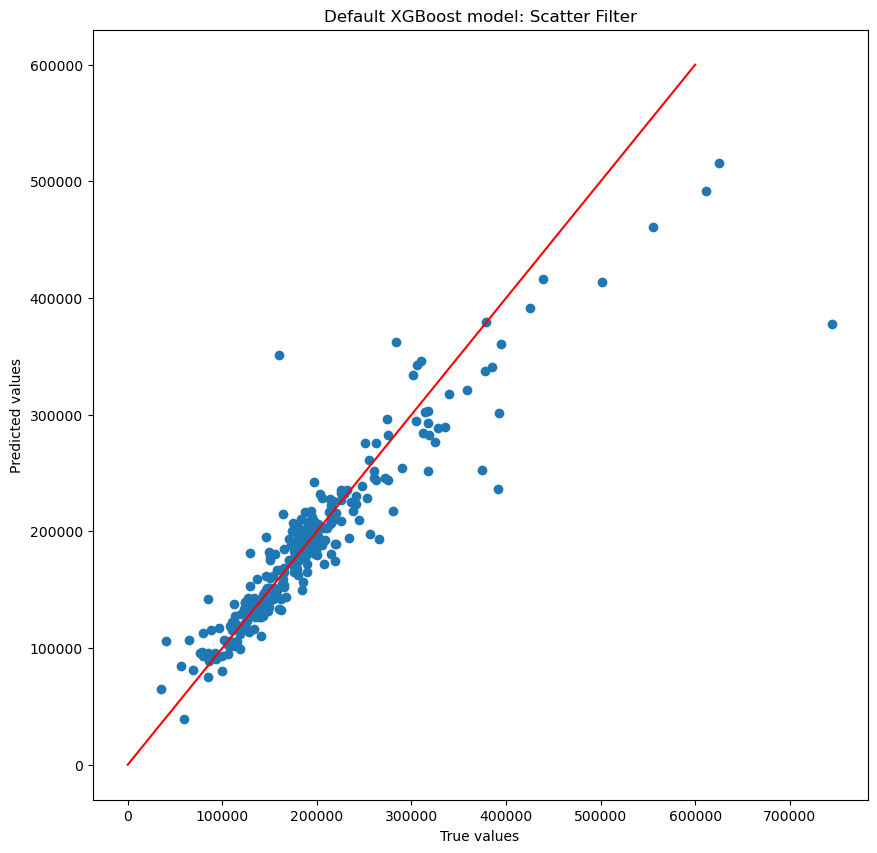

R^2: 0.835
RMSE: 36562.165
MAE: 19398.146
Pearson correlation: 0.923
Spearman correlation: 0.944


In [9]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Default XGBoost model: Scatter Filter")
plt.show()

pearson_corr, _ = stats.pearsonr(y_test, y_pred)
spearman_corr, _ = stats.spearmanr(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

# Optuna

In [10]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 750)
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     learning_rate = trial.suggest_loguniform('learning_rate', 5e-2, 0.5)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
#     gamma = trial.suggest_discrete_uniform('gamma', 0, 0.5, 0.1)
#     subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1)
#     colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1)

#     model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, random_state=SEED)
#     model.fit(x_train, y_train)

#     score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score



In [11]:
# study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=SEED))
# study.optimize(objective, n_trials=1000, show_progress_bar=True)

In [12]:
# study.best_params

In [13]:
###
{'n_estimators': 235,
 'max_depth': 5,
 'learning_rate': 0.06315273144693412,
 'min_child_weight': 1,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8}
 ###

{'n_estimators': 235,
 'max_depth': 5,
 'learning_rate': 0.06315273144693412,
 'min_child_weight': 1,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8}

In [14]:
# best_params = study.best_params
best_params = {'n_estimators': 235,
 'max_depth': 5,
 'learning_rate': 0.06315273144693412,
 'min_child_weight': 1,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8}
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_learning_rate = best_params['learning_rate']
best_min_child_weight = best_params['min_child_weight']
best_gamma = best_params['gamma']
best_subsample = best_params['subsample']
best_colsample_bytree = best_params['colsample_bytree']

best_XGB = XGBRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate, min_child_weight=best_min_child_weight, gamma=best_gamma, subsample=best_subsample, colsample_bytree=best_colsample_bytree, random_state=SEED)
best_XGB.fit(x_train, y_train)
best_y_pred = best_XGB.predict(x_test)


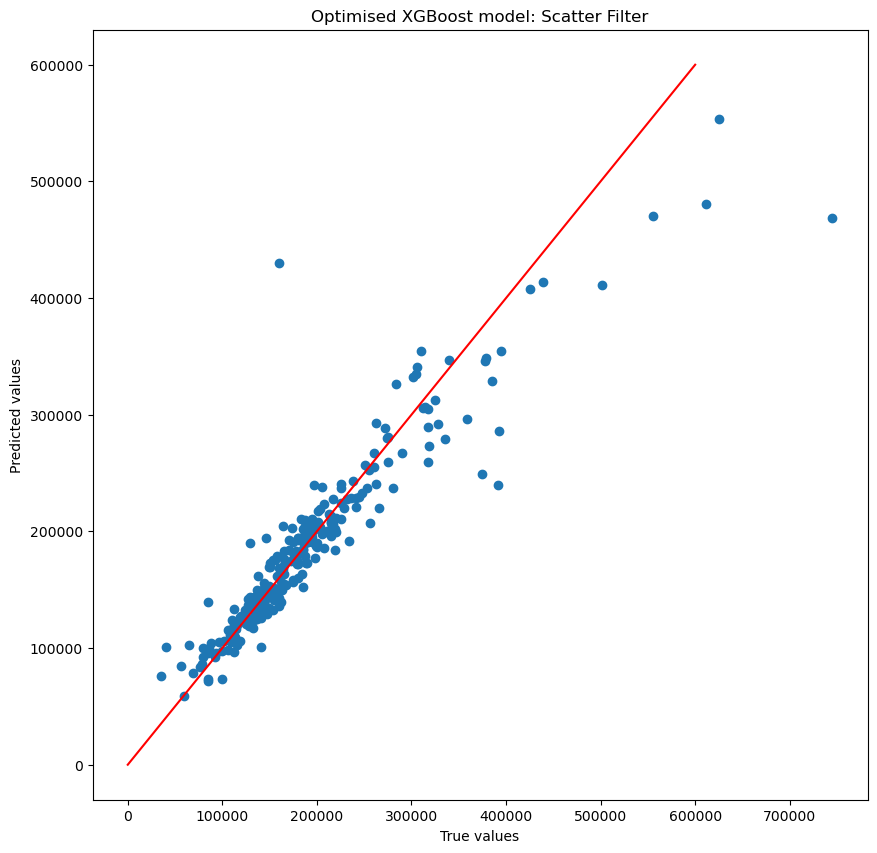

R^2: 0.856
RMSE: 34167.347
MAE: 17567.724
Pearson correlation: 0.931
Spearman correlation: 0.957


In [15]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, best_y_pred)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Optimised XGBoost model: Scatter Filter")
plt.show()

pearson_corr_best, _ = stats.pearsonr(y_test, best_y_pred)
spearman_corr_best, _ = stats.spearmanr(y_test, best_y_pred)
r2_best = r2_score(y_test, best_y_pred)
mae_best = mean_absolute_error(y_test, best_y_pred)
rmse_best = math.sqrt(mean_squared_error(y_test, best_y_pred))

print(f"R^2: {r2_best:.3f}")
print(f"RMSE: {rmse_best:.3f}")
print(f"MAE: {mae_best:.3f}")
print(f"Pearson correlation: {pearson_corr_best:.3f}")
print(f"Spearman correlation: {spearman_corr_best:.3f}")

# XGB for UMAP filterd data

In [16]:
X_UMAP = train_df_UMAP.drop('SalePrice', axis=1) #(1380, 65)
Y_UMAP = train_df_UMAP['SalePrice']

# Pass the data through the pipeline
X_preprocessed_UMAP = pipeline.fit_transform(X_UMAP) #(1380, 195)

# Train test split
x_train_UMAP, x_test_UMAP, y_train_UMAP, y_test_UMAP = train_test_split(X_preprocessed_UMAP, Y_UMAP, test_size=0.2, random_state=SEED)
# x_train_UMAP.shape #(1104, 195)

In [17]:
XGB_UMAP = XGBRegressor(random_state=SEED)

XGB_UMAP.fit(x_train_UMAP, y_train_UMAP)
y_pred_UMAP = XGB_UMAP.predict(x_test_UMAP)

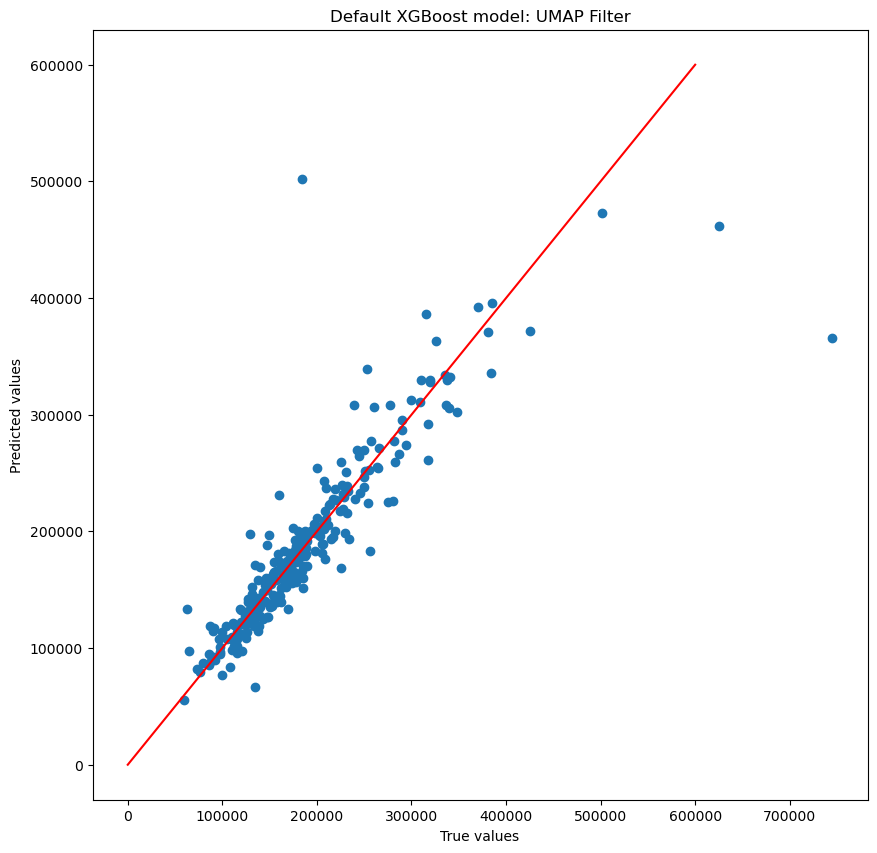

R^2: 0.782
RMSE: 37817.184
MAE: 17566.265
Pearson correlation: 0.885
Spearman correlation: 0.948


In [18]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_UMAP, y_pred_UMAP)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Default XGBoost model: UMAP Filter")
plt.show()

pearson_corr_UMAP, _ = stats.pearsonr(y_test_UMAP, y_pred_UMAP)
spearman_corr_UMAP, _ = stats.spearmanr(y_test_UMAP, y_pred_UMAP)
r2_UMAP = r2_score(y_test_UMAP, y_pred_UMAP)
mae_UMAP = mean_absolute_error(y_test_UMAP, y_pred_UMAP)
rmse_UMAP= math.sqrt(mean_squared_error(y_test_UMAP, y_pred_UMAP))

print(f"R^2: {r2_UMAP:.3f}")
print(f"RMSE: {rmse_UMAP:.3f}")
print(f"MAE: {mae_UMAP:.3f}")
print(f"Pearson correlation: {pearson_corr_UMAP:.3f}")
print(f"Spearman correlation: {spearman_corr_UMAP:.3f}")

In [19]:
# def objective_UMAP(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 750)
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     learning_rate = trial.suggest_loguniform('learning_rate', 5e-2, 0.5)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
#     gamma = trial.suggest_discrete_uniform('gamma', 0, 0.5, 0.1)
#     subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1)
#     colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1)

#     model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, random_state=SEED)
#     model.fit(x_train_UMAP, y_train_UMAP)

#     score = cross_val_score(model, x_train_UMAP, y_train_UMAP, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score



In [20]:
# study_UMAP = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=SEED))
# study_UMAP.optimize(objective_UMAP, n_trials=1000, show_progress_bar=True)

In [21]:
# study_UMAP.best_params

In [22]:
# best_params_UMAP = study_UMAP.best_params
best_params_UMAP = {'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.05503466451418128,
 'min_child_weight': 5,
 'gamma': 0.4,
 'subsample': 0.5,
 'colsample_bytree': 0.6}
best_n_estimators_UMAP = best_params_UMAP['n_estimators']
best_max_depth_UMAP = best_params_UMAP['max_depth']
best_learning_rate_UMAP = best_params_UMAP['learning_rate']
best_min_child_weight_UMAP = best_params_UMAP['min_child_weight']
best_gamma_UMAP = best_params_UMAP['gamma']
best_subsample_UMAP = best_params_UMAP['subsample']
best_colsample_bytree_UMAP = best_params_UMAP['colsample_bytree']

best_XGB_UMAP = XGBRegressor(n_estimators=best_n_estimators_UMAP, max_depth=best_max_depth_UMAP, learning_rate=best_learning_rate_UMAP, min_child_weight=best_min_child_weight_UMAP, gamma=best_gamma_UMAP, subsample=best_subsample_UMAP, colsample_bytree=best_colsample_bytree_UMAP, random_state=SEED)
best_XGB_UMAP.fit(x_train_UMAP, y_train_UMAP)
best_y_pred_UMAP = best_XGB_UMAP.predict(x_test_UMAP)

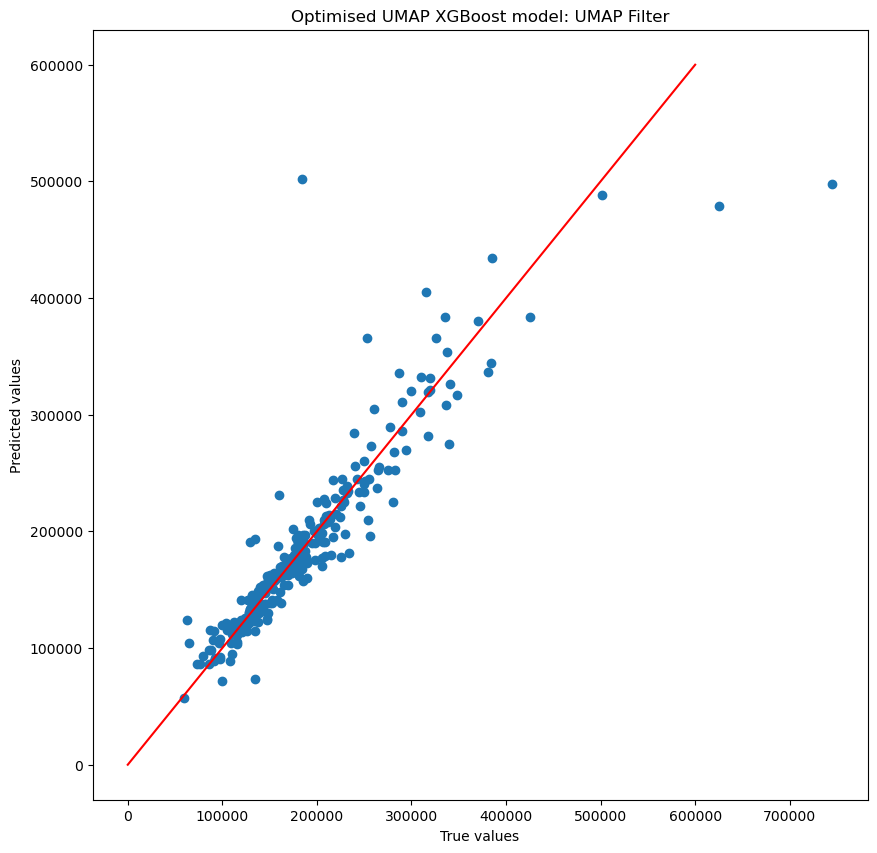

R^2: 0.832
RMSE: 33153.235
MAE: 16327.910
Pearson correlation: 0.913
Spearman correlation: 0.955


In [23]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_UMAP, best_y_pred_UMAP)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Optimised UMAP XGBoost model: UMAP Filter")
plt.show()

pearson_corr_best_UMAP, _ = stats.pearsonr(y_test_UMAP, best_y_pred_UMAP)
spearman_corr_best_UMAP, _ = stats.spearmanr(y_test_UMAP, best_y_pred_UMAP)
r2_best_UMAP = r2_score(y_test_UMAP, best_y_pred_UMAP)
mae_best_UMAP = mean_absolute_error(y_test_UMAP, best_y_pred_UMAP)
rmse_best_UMAP = math.sqrt(mean_squared_error(y_test_UMAP, best_y_pred_UMAP))

print(f"R^2: {r2_best_UMAP:.3f}")
print(f"RMSE: {rmse_best_UMAP:.3f}")
print(f"MAE: {mae_best_UMAP:.3f}")
print(f"Pearson correlation: {pearson_corr_best_UMAP:.3f}")
print(f"Spearman correlation: {spearman_corr_best_UMAP:.3f}")

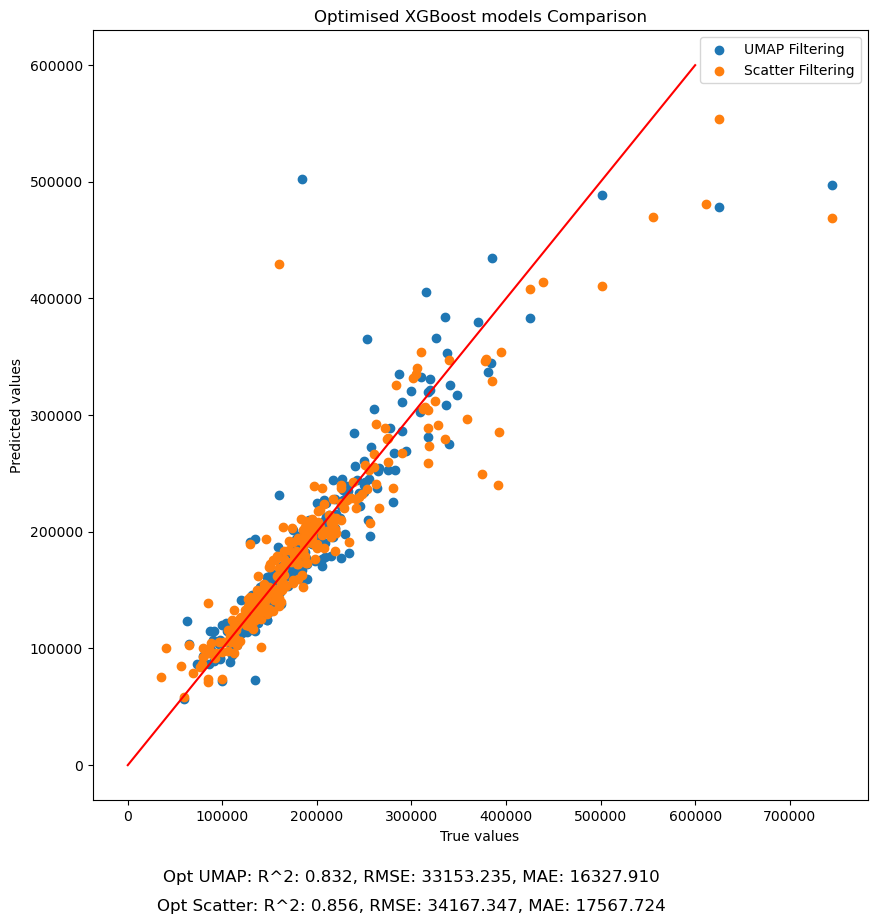

In [24]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_UMAP, best_y_pred_UMAP, label='UMAP Filtering')
plt.scatter(y_test, best_y_pred, label='Scatter Filtering')
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Optimised XGBoost models Comparison")

pearson_corr_best_UMAP, _ = stats.pearsonr(y_test_UMAP, best_y_pred_UMAP)
spearman_corr_best_UMAP, _ = stats.spearmanr(y_test_UMAP, best_y_pred_UMAP)
r2_best_UMAP = r2_score(y_test_UMAP, best_y_pred_UMAP)
mae_best_UMAP = mean_absolute_error(y_test_UMAP, best_y_pred_UMAP)
rmse_best_UMAP = math.sqrt(mean_squared_error(y_test_UMAP, best_y_pred_UMAP))

plt.text(300000, -100000, f"Opt UMAP: R^2: {r2_best_UMAP:.3f}, RMSE: {rmse_best_UMAP:.3f}, MAE: {mae_best_UMAP:.3f}", ha='center', fontsize=12)
plt.text(300000, -125000, f"Opt Scatter: R^2: {r2_best:.3f}, RMSE: {rmse_best:.3f}, MAE: {mae_best:.3f}", ha='center', fontsize=12)
        
plt.legend()
plt.show();

# XGBoost Hybrid

In [25]:
X_hyb = train_df_hyb.drop('SalePrice', axis=1)
Y_hyb = train_df_hyb['SalePrice']

# Pass the data through the pipeline
X_preprocessed_hyb = pipeline.fit_transform(X_hyb)

# Train test split
x_train_hyb, x_test_hyb, y_train_hyb, y_test_hyb = train_test_split(X_preprocessed_hyb, Y_hyb, test_size=0.2, random_state=SEED)


In [26]:
XGB_hyb = XGBRegressor(random_state=SEED)

XGB_hyb.fit(x_train_hyb, y_train_hyb)
y_pred_hyb = XGB_hyb.predict(x_test_hyb)

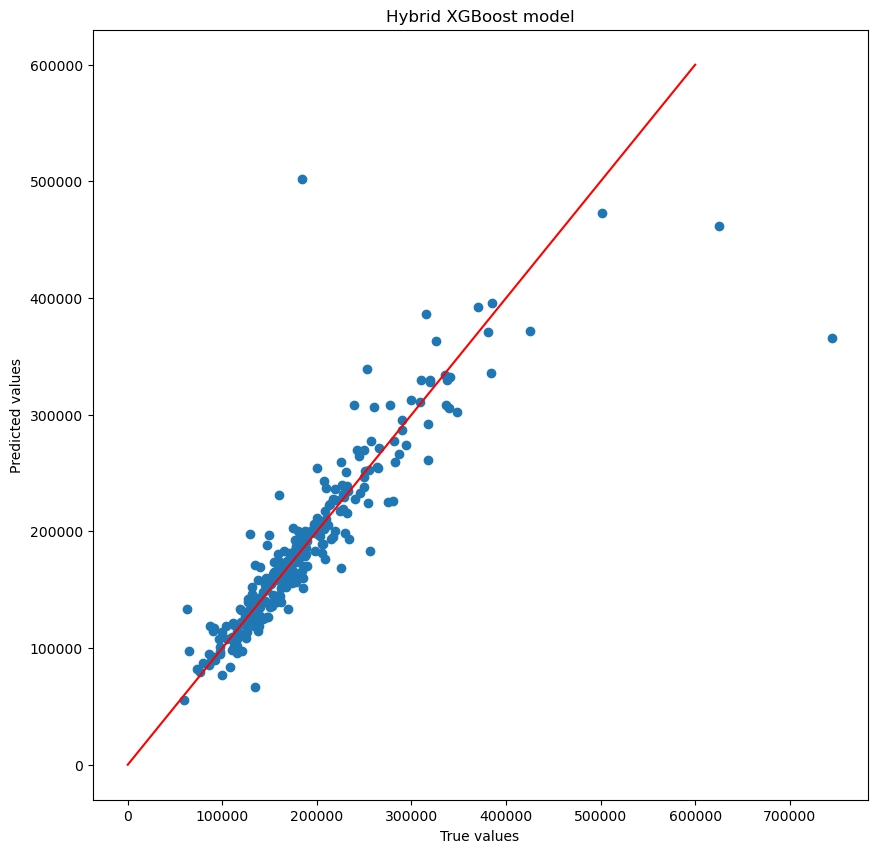

R^2: 0.782
RMSE: 37817.184
MAE: 17566.265
Pearson correlation: 0.885
Spearman correlation: 0.948


In [27]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_hyb, y_pred_hyb)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Hybrid XGBoost model")
plt.show()

pearson_corr_hyb, _ = stats.pearsonr(y_test_hyb, y_pred_hyb)
spearman_corr_hyb, _ = stats.spearmanr(y_test_hyb, y_pred_hyb)
r2_hyb = r2_score(y_test_hyb, y_pred_hyb)
mae_hyb = mean_absolute_error(y_test_hyb, y_pred_hyb)
rmse_hyb = math.sqrt(mean_squared_error(y_test_hyb, y_pred_hyb))

print(f"R^2: {r2_hyb:.3f}")
print(f"RMSE: {rmse_hyb:.3f}")
print(f"MAE: {mae_hyb:.3f}")
print(f"Pearson correlation: {pearson_corr_hyb:.3f}")
print(f"Spearman correlation: {spearman_corr_hyb:.3f}")

In [28]:
XGB_results = {'Parameters': ["Scat Default", "Scat Optimised", "UMAP Default", "UMAP Optimised", "Hybrid Default"],
               'RMSE': [rmse, rmse_best, rmse_UMAP, rmse_best_UMAP, rmse_hyb],
               'MAE': [mae, mae_best, mae_UMAP, mae_best_UMAP, mae_hyb],
               'R^2': [r2, r2_best, r2_UMAP, r2_best_UMAP, r2_hyb],
               'Pearson correlation': [pearson_corr, pearson_corr_best, pearson_corr_UMAP, pearson_corr_best_UMAP, pearson_corr_hyb],
               'Spearman correlation': [spearman_corr, spearman_corr_best, spearman_corr_UMAP, spearman_corr_best_UMAP, spearman_corr_hyb]}
XGB_results_df = pd.DataFrame(XGB_results)
XGB_results_df.set_index('Parameters', inplace=True)
XGB_results_df = XGB_results_df.applymap(lambda x: round(x, 3))
XGB_results_df.to_csv("../Data/Data/Results/XGB_results.csv")
XGB_results_df

/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_16436/1135904106.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  XGB_results_df = XGB_results_df.applymap(lambda x: round(x, 3))


,RMSE,MAE,R^2,Pearson correlation,Spearman correlation
Parameters,,,,,
Scat Default,36562.165,19398.146,0.835,0.923,0.944
Scat Optimised,34167.347,17567.724,0.856,0.931,0.957
UMAP Default,37817.184,17566.265,0.782,0.885,0.948
UMAP Optimised,33153.235,16327.910,0.832,0.913,0.955
Hybrid Default,37817.184,17566.265,0.782,0.885,0.948


### Hybrid is not worth optimising
### Our performance metrics are not as successful as the other default filtering methods

# Submission

In [29]:
test_file_path = "../Data/Data/Initial Filtering/test_filter.csv"
test_df = pd.read_csv(test_file_path) #(1459, 66)

X_preprocessed_sub = pipeline.transform(test_df) 
y_pred_UMAP =  best_XGB_UMAP.predict(X_preprocessed_sub)

X_UMAP = train_df_UMAP.drop('SalePrice', axis=1)
Y_UMAP = train_df_UMAP['SalePrice']

# Pass the data through the pipeline
X_preprocessed_UMAP = pipeline.fit_transform(X_UMAP)

# Train test split
x_train_UMAP, x_test_UMAP, y_train_UMAP, y_test_UMAP = train_test_split(X_preprocessed_UMAP, Y_UMAP, test_size=0.2, random_state=SEED)

XGB_UMAP = XGBRegressor(random_state=SEED)

XGB_UMAP.fit(x_train_UMAP, y_train_UMAP)
y_pred_UMAP = XGB_UMAP.predict(x_test_UMAP)

In [30]:
submission = test_df[['Id']]
submission['SalePrice'] = y_pred_UMAP

submission.to_csv("../Data/Data/Submission/submission.csv", index=False)
submission.head()

/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_16436/1753473222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['SalePrice'] = y_pred_UMAP


,Id,SalePrice
0,1461,126901.843750
1,1462,168592.921875
2,1463,189385.937500
3,1464,198213.031250
4,1465,181720.078125


In [31]:
submission.shape

(1459, 2)